## Build a Conditional GAN

Learning Objectives
1. Learn the technical difference between a conditional and unconditional GAN.
2. Understand the distinction between the class and noise vector in a conditional GAN.

## TRICK

### .repeat()

In [54]:
z_dim= 64
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

### noise_and_labels = combine_vectors(fake_noise, one_hot_labels) | torch.cat

In [ ]:
combined = torch.cat((x.float(),y.float()),1)

### interpolation vector between the two labels

In [55]:
def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

### interpolation noises | torch.linspace + first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

In [ ]:
percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

## Tool

In [2]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

## Generator and Noise

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

## Discriminator

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Class Input

In [5]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, n_classes)

In [6]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    combined = torch.cat((x.float(),y.float()),1)
    return combined

## Training

In [7]:
mnist_shape = (1, 28, 28)
n_classes = 10

In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

### C x 28 x 28

In [9]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''

    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0]+n_classes
    
    return generator_input_dim, discriminator_im_chan

In [10]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

In [11]:
print(generator_input_dim, discriminator_im_chan)

74 11


In [12]:
gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [14]:
# GRADED CELL
cur_step = 0
generator_losses = []
discriminator_losses = []

  1%|          | 4/469 [00:00<01:39,  4.66it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


  6%|▋         | 30/469 [00:01<00:16, 26.46it/s]

Step 500: Generator loss: 2.259835547208786, discriminator loss: 0.23521160436421631


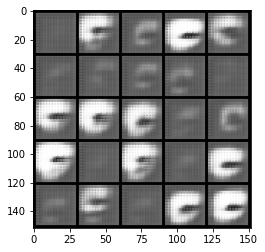

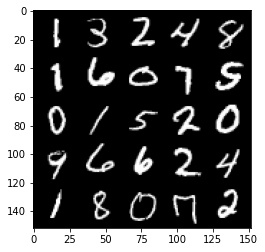

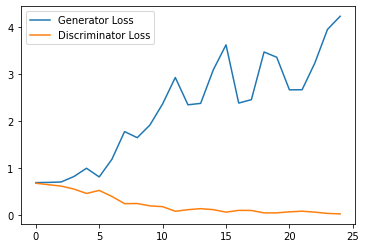

 13%|█▎        | 62/469 [00:02<00:17, 23.46it/s]

Step 1000: Generator loss: 4.422737941265106, discriminator loss: 0.040935188734903934


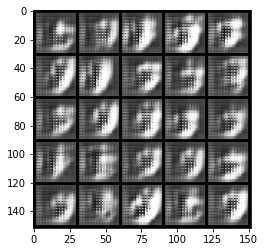

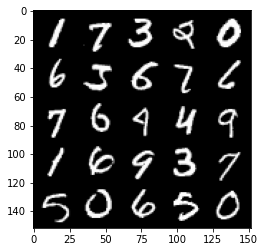

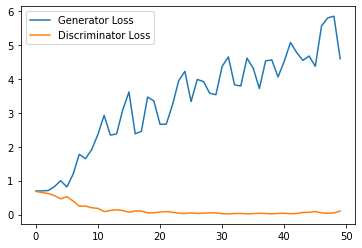

 20%|█▉        | 93/469 [00:03<00:15, 24.41it/s]

Step 1500: Generator loss: 4.708374171257019, discriminator loss: 0.04266328219836578


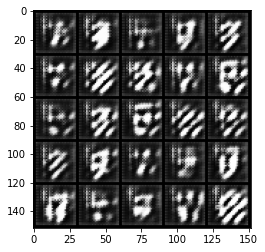

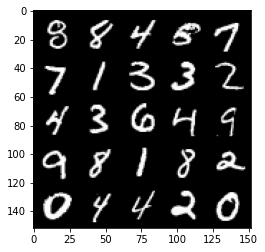

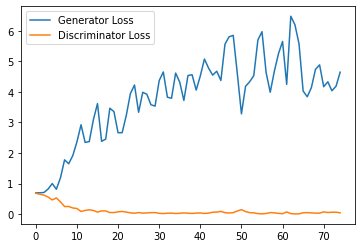

 26%|██▌       | 123/469 [00:05<00:12, 26.86it/s]

Step 2000: Generator loss: 3.744339407920837, discriminator loss: 0.08653872479870915


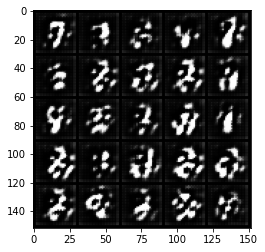

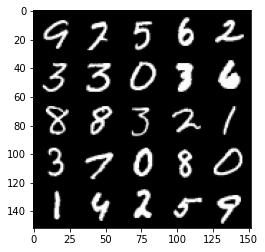

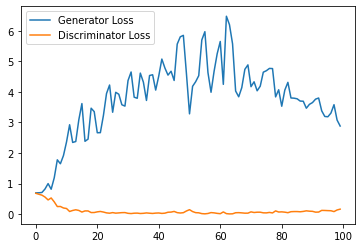

 33%|███▎      | 153/469 [00:06<00:13, 23.71it/s]

Step 2500: Generator loss: 2.71164732336998, discriminator loss: 0.22889358729124068


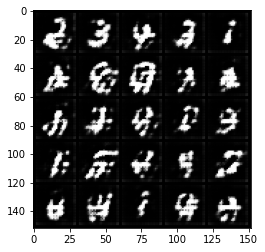

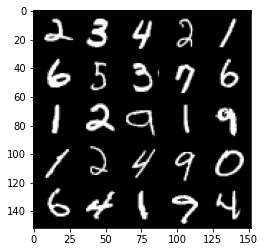

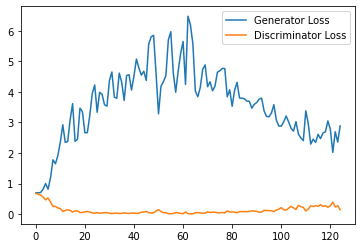

 40%|███▉      | 186/469 [00:07<00:12, 23.01it/s]

Step 3000: Generator loss: 2.250188875198364, discriminator loss: 0.2681927668452263


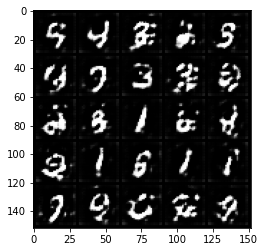

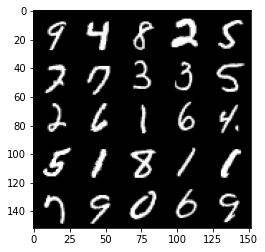

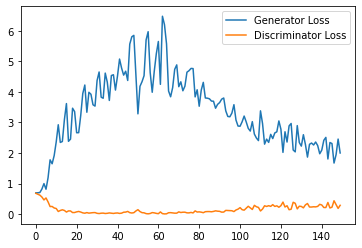

 46%|████▌     | 216/469 [00:08<00:10, 24.02it/s]

Step 3500: Generator loss: 2.242119134426117, discriminator loss: 0.29351972667872905


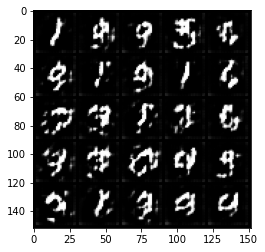

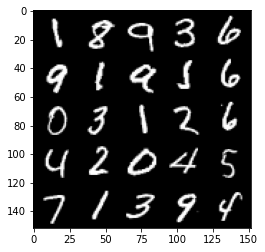

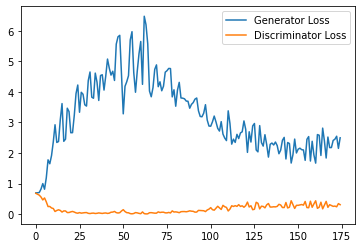

 52%|█████▏    | 246/469 [00:10<00:09, 24.56it/s]

Step 4000: Generator loss: 2.1892185187339783, discriminator loss: 0.30680557459592817


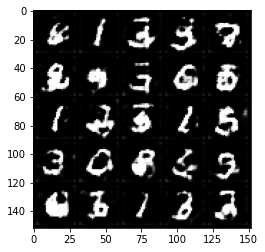

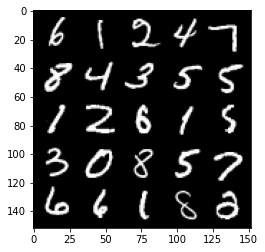

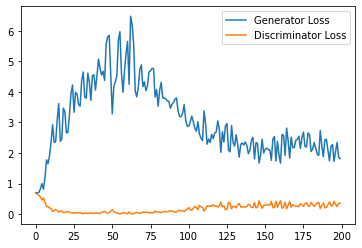

 59%|█████▉    | 279/469 [00:12<00:08, 21.49it/s]

Step 4500: Generator loss: 2.01967511677742, discriminator loss: 0.3253381986916065


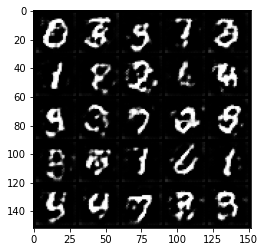

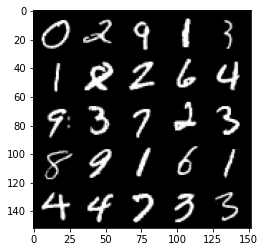

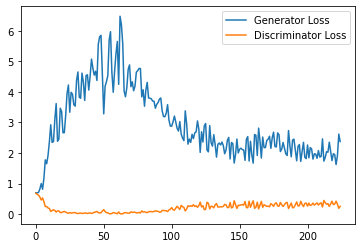

 66%|██████▌   | 309/469 [00:13<00:07, 22.72it/s]

Step 5000: Generator loss: 1.8813469514846801, discriminator loss: 0.3478778257369995


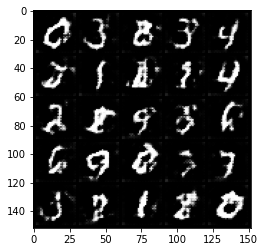

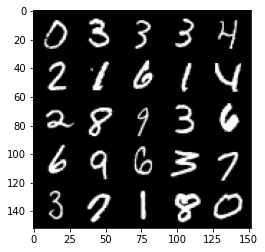

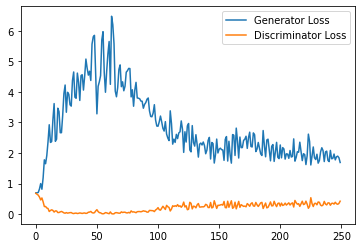

 72%|███████▏  | 339/469 [00:13<00:05, 25.01it/s]

Step 5500: Generator loss: 1.9488569786548615, discriminator loss: 0.3605378139615059


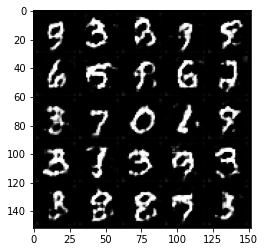

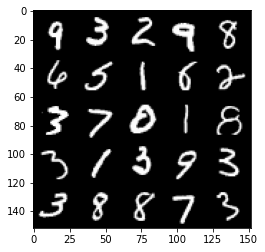

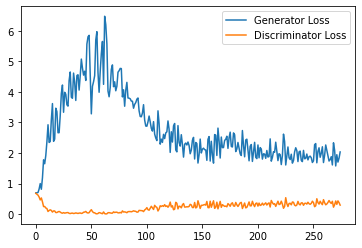

 79%|███████▉  | 371/469 [00:15<00:04, 23.24it/s]

Step 6000: Generator loss: 1.8779185194969177, discriminator loss: 0.3911691773831844


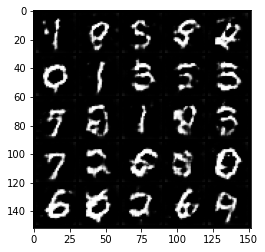

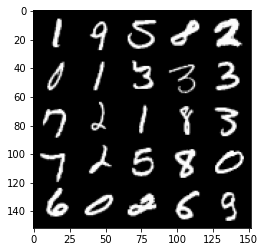

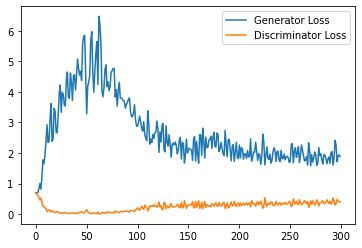

 86%|████████▌ | 402/469 [00:16<00:02, 23.99it/s]

Step 6500: Generator loss: 1.8622957339286805, discriminator loss: 0.4190107490718365


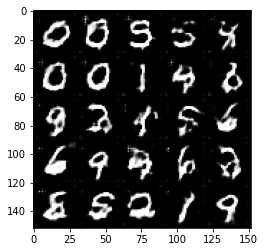

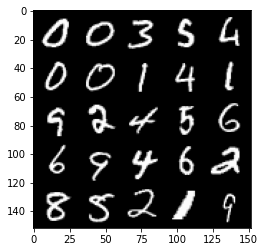

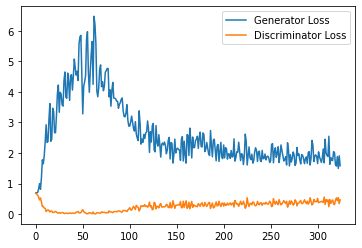

 92%|█████████▏| 432/469 [00:18<00:01, 24.46it/s]

Step 7000: Generator loss: 1.5909082913398742, discriminator loss: 0.4293743745684624


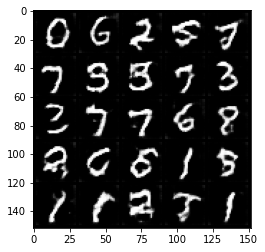

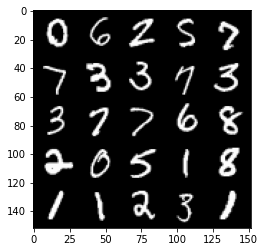

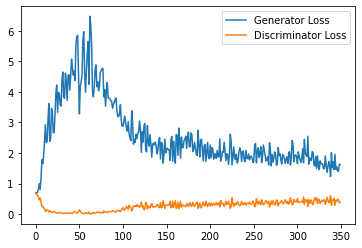

 99%|█████████▉| 465/469 [00:19<00:00, 25.27it/s]

Step 7500: Generator loss: 1.5481815189123154, discriminator loss: 0.43659018671512606


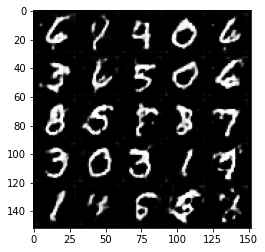

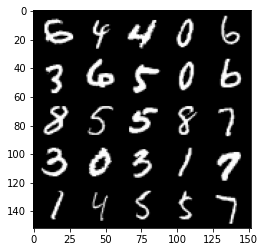

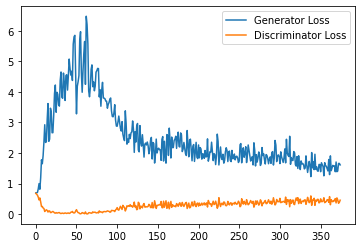

  6%|▌         | 27/469 [00:01<00:20, 21.97it/s]

Step 8000: Generator loss: 1.54997569835186, discriminator loss: 0.46210085567831993


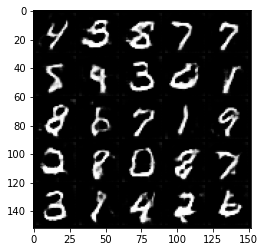

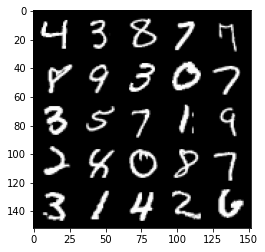

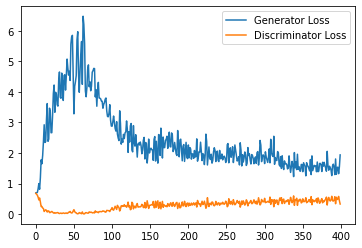

 12%|█▏        | 57/469 [00:02<00:15, 26.71it/s]

Step 8500: Generator loss: 1.4261464343070984, discriminator loss: 0.47294901847839355


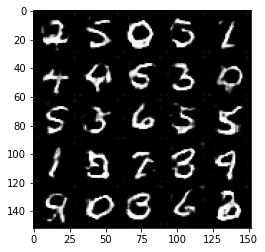

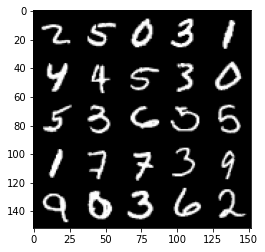

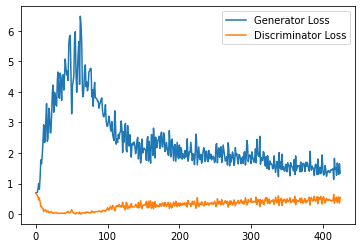

 19%|█▊        | 87/469 [00:03<00:16, 23.25it/s]

Step 9000: Generator loss: 1.4478159157037735, discriminator loss: 0.48611727464199067


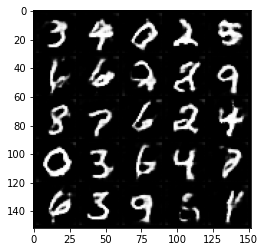

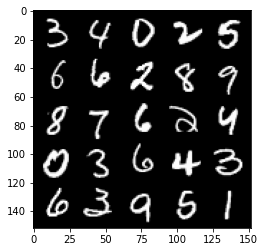

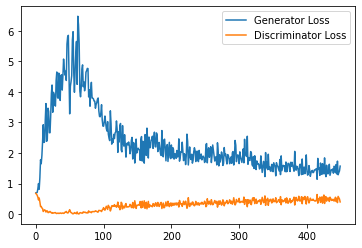

 26%|██▌       | 120/469 [00:05<00:15, 23.25it/s]

Step 9500: Generator loss: 1.4201176373958588, discriminator loss: 0.49778316020965574


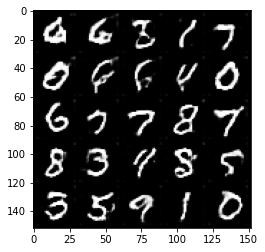

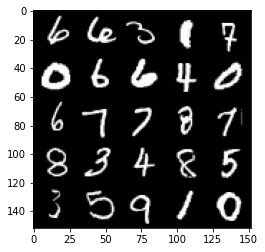

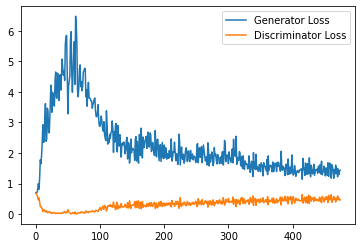

 32%|███▏      | 150/469 [00:05<00:11, 26.94it/s]

Step 10000: Generator loss: 1.3124904738664627, discriminator loss: 0.5099790149331093


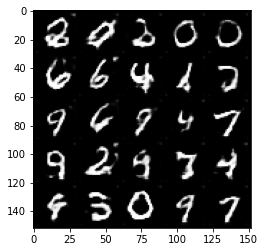

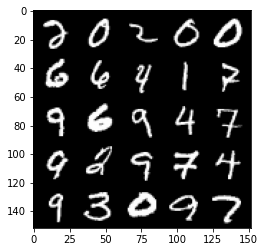

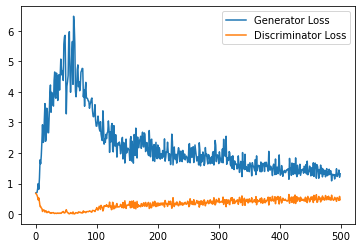

 38%|███▊      | 180/469 [00:07<00:12, 23.65it/s]

Step 10500: Generator loss: 1.320629033446312, discriminator loss: 0.5175398244261742


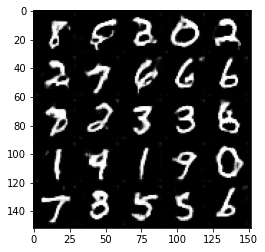

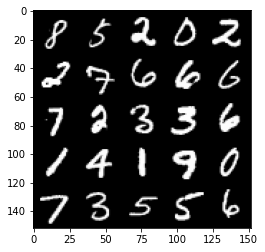

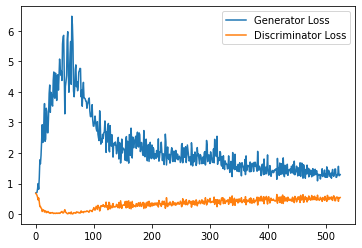

 45%|████▌     | 213/469 [00:09<00:10, 23.46it/s]

Step 11000: Generator loss: 1.2961230256557466, discriminator loss: 0.5193335366845131


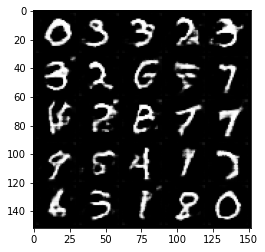

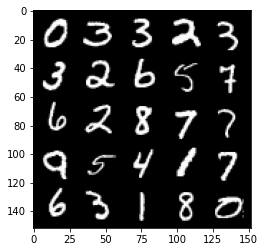

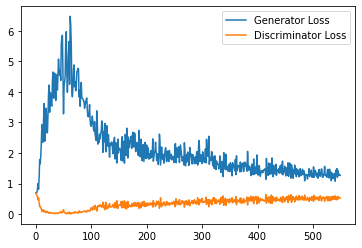

 52%|█████▏    | 243/469 [00:09<00:08, 25.50it/s]

Step 11500: Generator loss: 1.288038496017456, discriminator loss: 0.5263556673526764


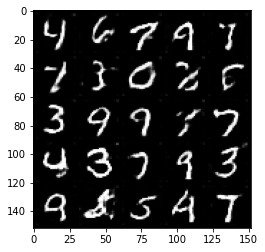

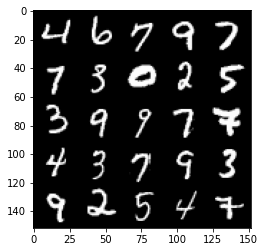

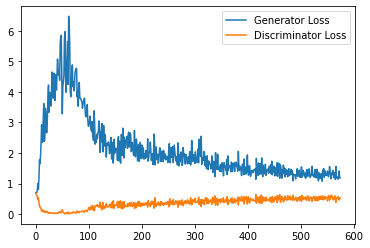

 59%|█████▊    | 275/469 [00:11<00:08, 23.27it/s]

Step 12000: Generator loss: 1.2268226914405822, discriminator loss: 0.540451600909233


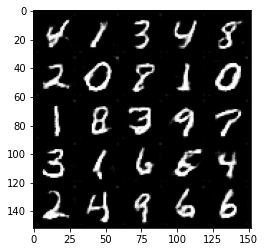

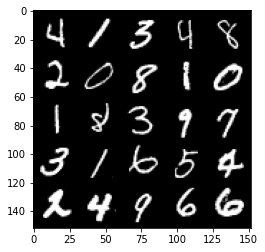

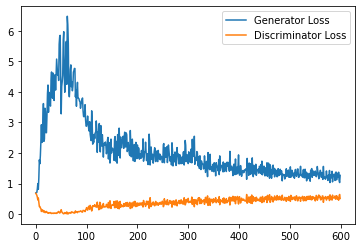

 65%|██████▌   | 306/469 [00:11<00:06, 26.48it/s]

Step 12500: Generator loss: 1.2220525782108307, discriminator loss: 0.5391991667151451


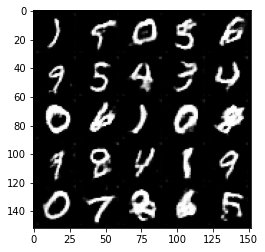

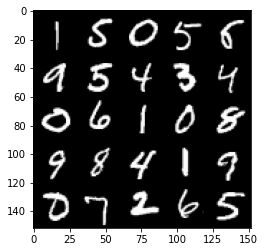

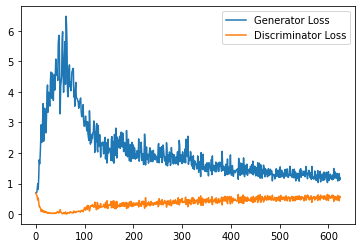

 72%|███████▏  | 336/469 [00:12<00:05, 25.81it/s]

Step 13000: Generator loss: 1.141914183139801, discriminator loss: 0.5464996058940887


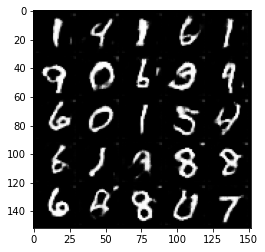

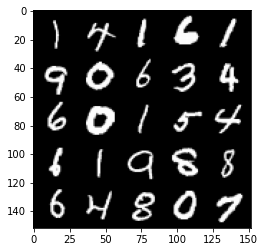

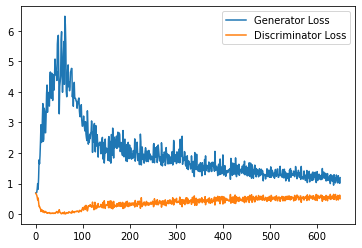

 78%|███████▊  | 366/469 [00:13<00:03, 26.24it/s]

Step 13500: Generator loss: 1.1416880600452424, discriminator loss: 0.551258557677269


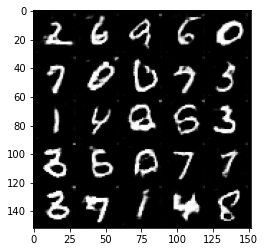

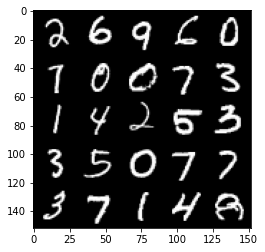

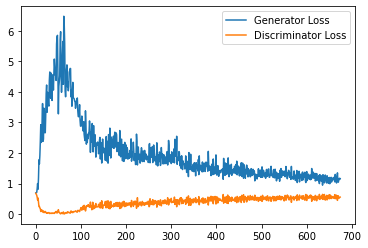

 85%|████████▌ | 399/469 [00:16<00:02, 25.83it/s]

Step 14000: Generator loss: 1.178311039686203, discriminator loss: 0.5619129223823547


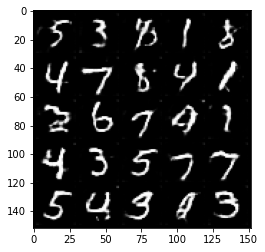

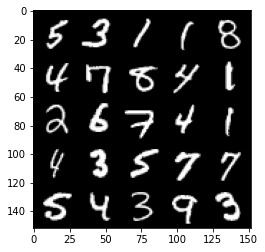

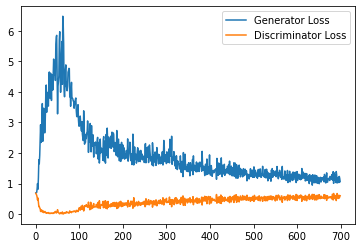

 91%|█████████▏| 429/469 [00:17<00:01, 25.72it/s]

Step 14500: Generator loss: 1.142970676779747, discriminator loss: 0.5601853768229484


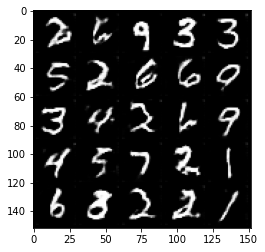

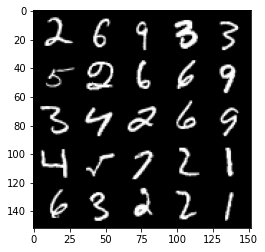

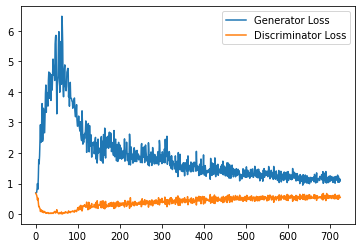

 98%|█████████▊| 459/469 [00:17<00:00, 23.88it/s]

Step 15000: Generator loss: 1.150293941617012, discriminator loss: 0.5657365834712982


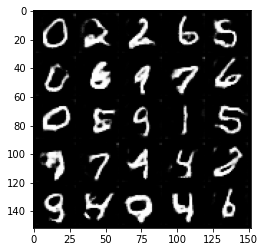

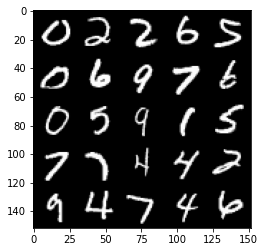

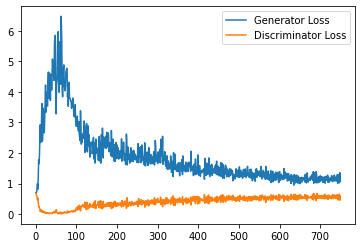

  4%|▍         | 21/469 [00:00<00:17, 26.04it/s]

Step 15500: Generator loss: 1.132032911300659, discriminator loss: 0.5628835175037384


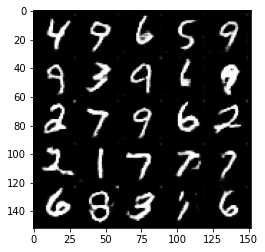

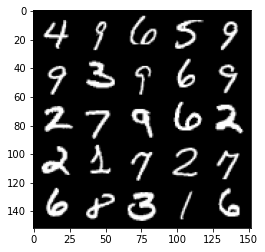

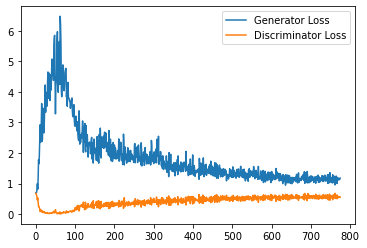

 12%|█▏        | 54/469 [00:02<00:16, 25.46it/s]

Step 16000: Generator loss: 1.1364441894292832, discriminator loss: 0.5652513918280602


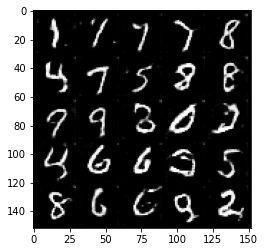

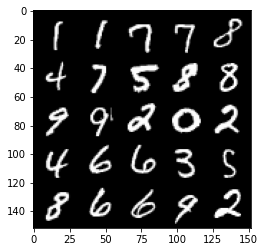

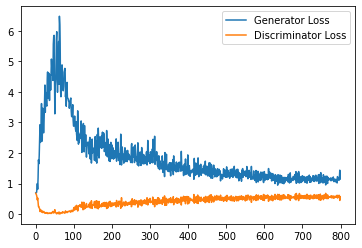

 18%|█▊        | 84/469 [00:03<00:16, 22.82it/s]

Step 16500: Generator loss: 1.1280526915788651, discriminator loss: 0.5766657464504242


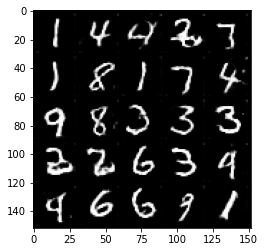

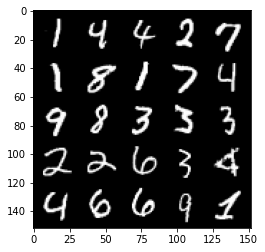

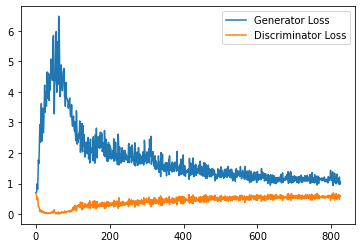

 24%|██▍       | 114/469 [00:04<00:13, 26.36it/s]

Step 17000: Generator loss: 1.1017857820987702, discriminator loss: 0.5801590032577515


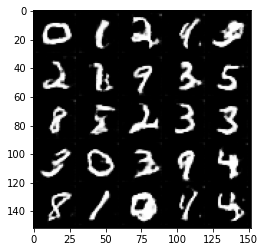

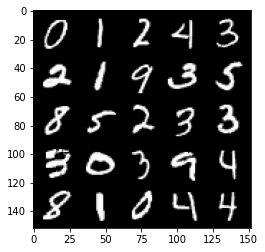

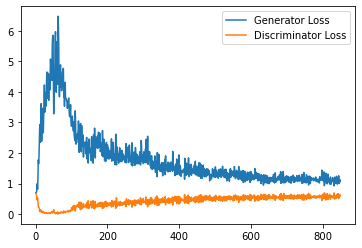

 31%|███▏      | 147/469 [00:06<00:13, 23.90it/s]

Step 17500: Generator loss: 1.121024372935295, discriminator loss: 0.5729454953074455


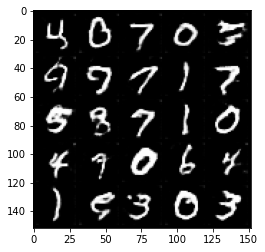

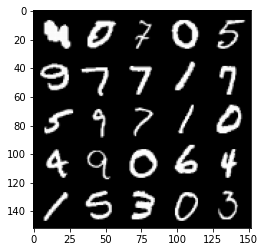

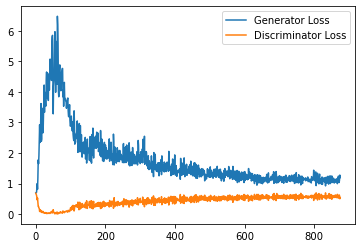

 38%|███▊      | 177/469 [00:07<00:12, 23.15it/s]

Step 18000: Generator loss: 1.09780688560009, discriminator loss: 0.58622364538908


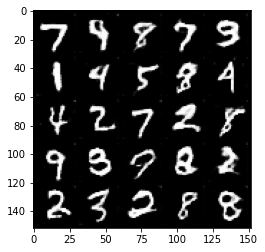

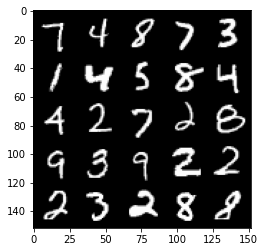

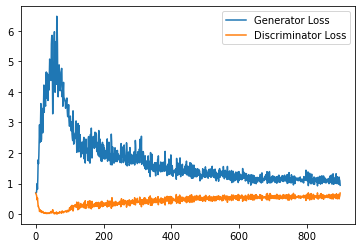

 44%|████▍     | 207/469 [00:08<00:10, 25.50it/s]

Step 18500: Generator loss: 1.0991491593122482, discriminator loss: 0.5836556376218796


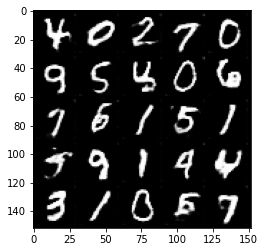

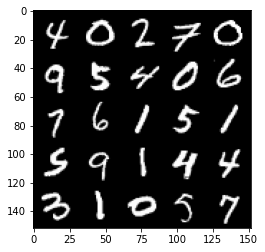

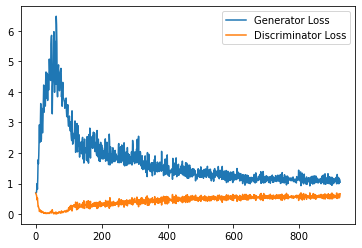

 51%|█████     | 240/469 [00:10<00:09, 23.10it/s]

Step 19000: Generator loss: 1.0854150302410126, discriminator loss: 0.5748293244242668


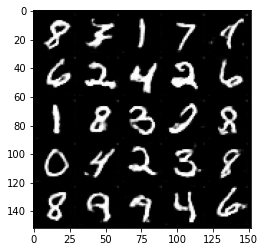

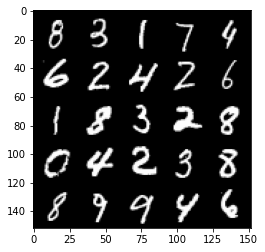

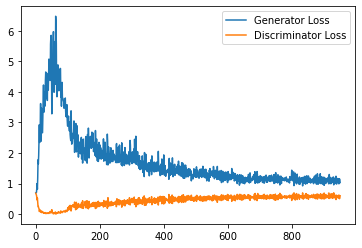

 58%|█████▊    | 270/469 [00:11<00:08, 23.61it/s]

Step 19500: Generator loss: 1.0501304737329482, discriminator loss: 0.5819280232787132


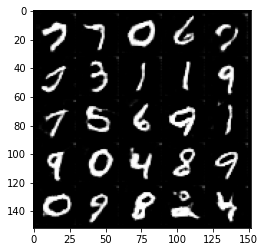

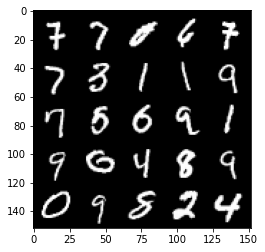

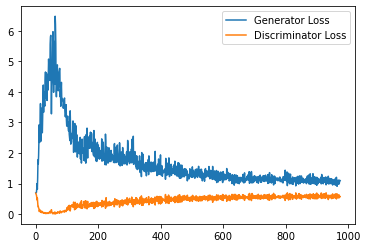

 64%|██████▍   | 300/469 [00:11<00:06, 25.96it/s]

Step 20000: Generator loss: 1.110267803788185, discriminator loss: 0.5763333795666694


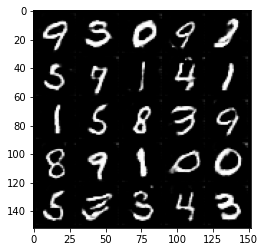

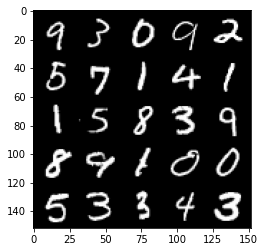

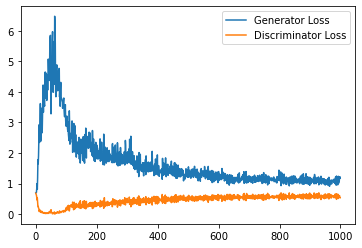

 71%|███████   | 333/469 [00:13<00:05, 23.74it/s]

Step 20500: Generator loss: 1.0378739432096482, discriminator loss: 0.592958865582943


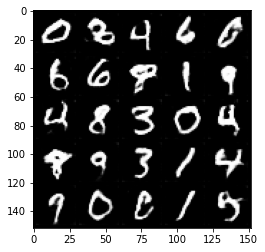

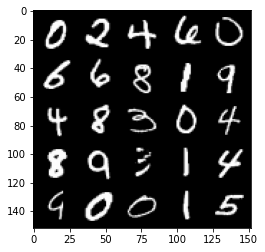

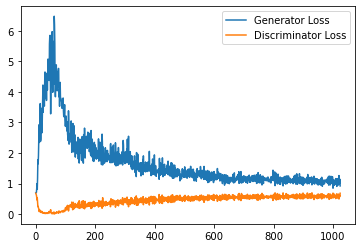

 77%|███████▋  | 363/469 [00:13<00:04, 26.34it/s]

Step 21000: Generator loss: 1.0610268919467927, discriminator loss: 0.5801036497354507


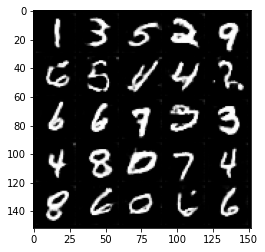

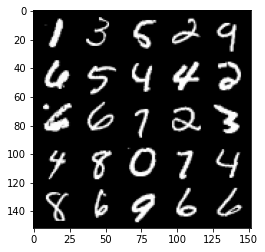

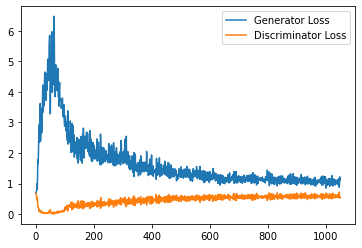

 84%|████████▍ | 393/469 [00:16<00:03, 23.83it/s]

Step 21500: Generator loss: 1.0507327667474746, discriminator loss: 0.5879438430070877


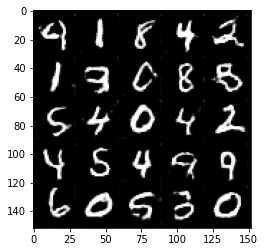

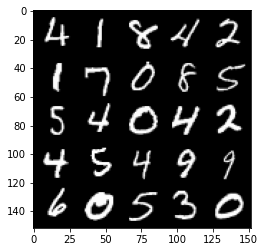

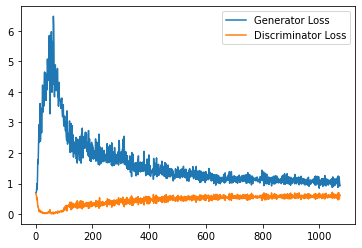

 91%|█████████ | 425/469 [00:16<00:01, 27.79it/s]

Step 22000: Generator loss: 1.0397585484981537, discriminator loss: 0.5774933133125305


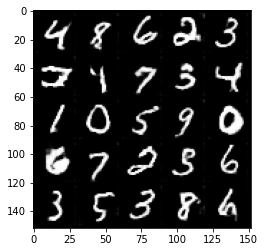

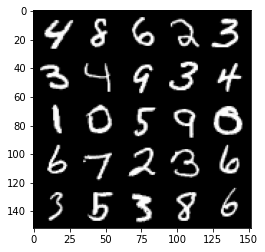

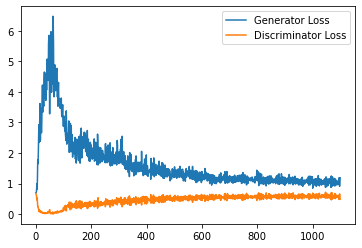

 97%|█████████▋| 456/469 [00:17<00:00, 25.88it/s]

Step 22500: Generator loss: 1.021985925912857, discriminator loss: 0.585614528119564


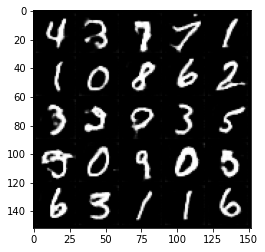

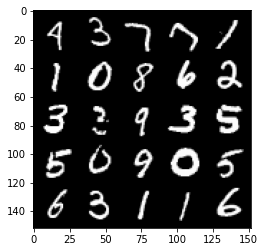

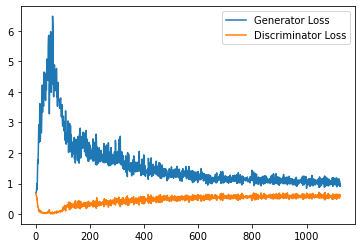

  4%|▍         | 18/469 [00:00<00:17, 25.91it/s]

Step 23000: Generator loss: 1.0435220894813537, discriminator loss: 0.5738915796875954


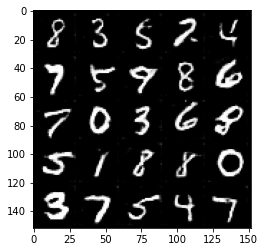

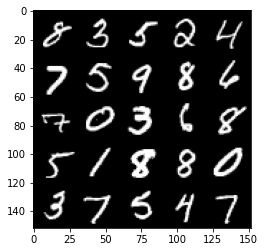

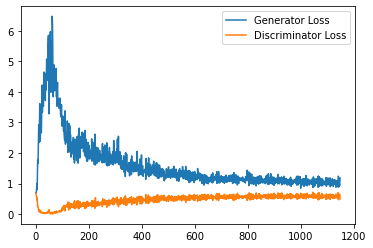

 35%|███▍      | 162/469 [00:06<00:11, 26.09it/s]

KeyboardInterrupt: 

In [15]:
for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        #### START CODE HERE ####
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)
        
        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

## Exploration

### Changing the class Vector

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

In [16]:
gen = gen.eval()

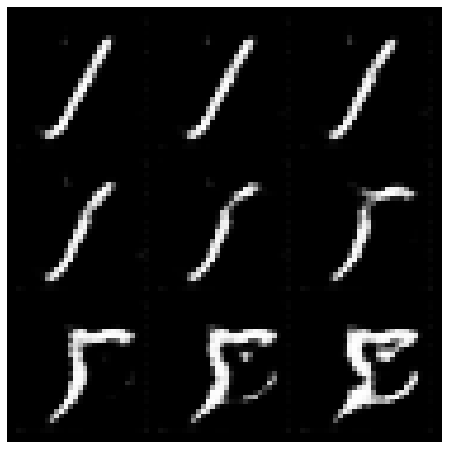

In [32]:
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 5 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

#### Changing the Noise Vector

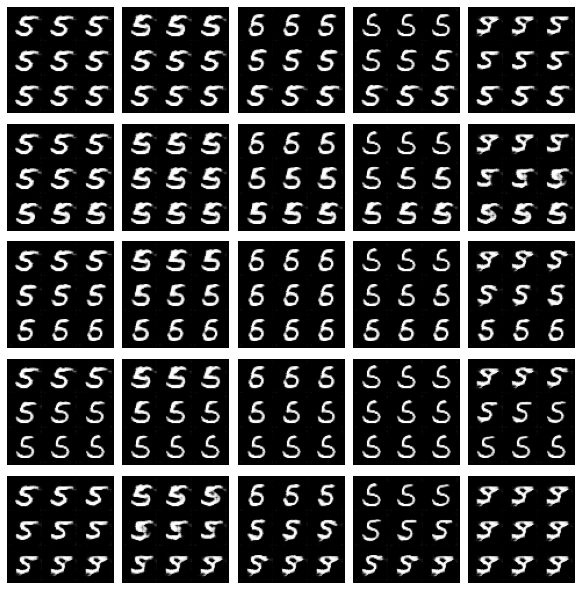

In [50]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()